## Social graphs & intercations
- Assignment 1
- Submission date: September 30th 2025

### Group 101
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

# Formalia: (Delete before hand-in)

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


# Assignment 1.2: Stats and visualization of the Rock Music Network

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Explain your process in words*

* *Simple network statistics and analysis*.

  * **Note related to this and the following exercise**. It is nice to have the dataset underlying the statistics and visualization available when we grade. Therefore, I recommend that you create a small *network dataset*, which is simply your graph stored in some format that you like (since it's only a few hundred nodes and a few thousand edges, it won't take up a lot of space). You can then place that network one of your group members' GitHub account (or some other server that's available online) and have your Jupyter Notebook fetch that dataset when it runs. (It's OK to use an LLM for help with setting this up, if it seems difficult). 

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

In [1]:
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_band_network.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open(local_network, "rb") as fh:
        G_bands = nx.read_adjlist(fh, **read_graph_kwargs)
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rb") as fh:
        G_bands = nx.read_adjlist(fh, **read_graph_kwargs)
print(
    f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges."
)


Loaded graph with 488 nodes and 7323 edges.


Number of nodes: 488
Number of edges: 7323


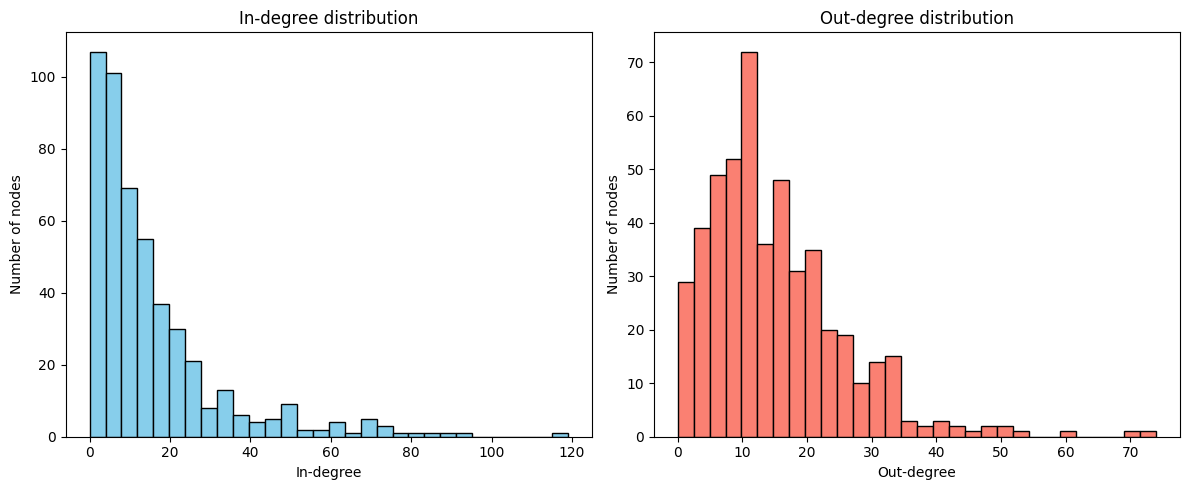

Top 5 bands by in-degree:
Led Zeppelin: 119
Bob Dylan: 95
Queen (band): 88
Metallica: 85
David Bowie: 83

Top 5 bands by out-degree:
Led Zeppelin: 119
Bob Dylan: 95
Queen (band): 88
Metallica: 85
David Bowie: 83


In [2]:
import matplotlib.pyplot as plt
# Statistics

# 1) Nodes
print("Number of nodes:", G_bands.number_of_nodes())
# 2) Edges
print("Number of edges:", G_bands.number_of_edges())
# 3) Plot in and out degree distribution
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())

# Plotting degree distributions
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(list(in_degrees.values()), bins=30, color="skyblue", edgecolor="black")
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of nodes")

plt.subplot(122)
plt.hist(list(out_degrees.values()), bins=30, color="salmon", edgecolor="black")
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.show()

# Top 5 most connected bands (in-degree) and (out-degree)
top5_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top5_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 bands by in-degree:")
for band, degree in top5_in:
    print(f"{band}: {degree}")

print("\nTop 5 bands by out-degree:")
for band, degree in top5_in:
    print(f"{band}: {degree}")

Graph with 488 nodes and 6019 edges
Top 5 (Undirected) bands by in-degree:
Led Zeppelin: 127
Queen (band): 100
Bob Dylan: 100
Deep Purple: 96
Metallica: 96


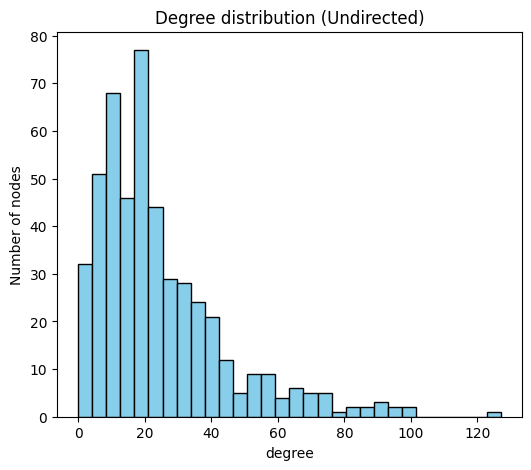

In [3]:
# Convert to undirected graph + basic statistics
G_band_undirected = G_bands.to_undirected()
print(G_band_undirected)

degrees_undirected = dict(G_band_undirected.degree())

# Plotting degree distributions
plt.figure(figsize=(6, 5))
plt.hist(list(degrees_undirected.values()), bins=30, color="skyblue", edgecolor="black")
plt.title("Degree distribution (Undirected)")
plt.xlabel("degree")
plt.ylabel("Number of nodes")

top5_undirected = sorted(
    degrees_undirected.items(),
    key=lambda x: x[1],
    reverse=True,
)[:5]

print("Top 5 (Undirected) bands by in-degree:")
for band, degree in top5_undirected:
    print(f"{band}: {degree}")

In [4]:
import json

local_bands_len = "data/rock_band_content_lengths.json"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_bands_len}"

if os.path.exists(local_bands_len):
    with open(local_bands_len, "r", encoding="utf-8") as fh:
        bands_content_lengths = json.load(fh)
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    bands_content_lengths = json.loads(r.content.decode("utf-8"))

print(f"Loaded {len(bands_content_lengths)} rock bands wiki content lengths")

Loaded 488 rock bands wiki content lengths


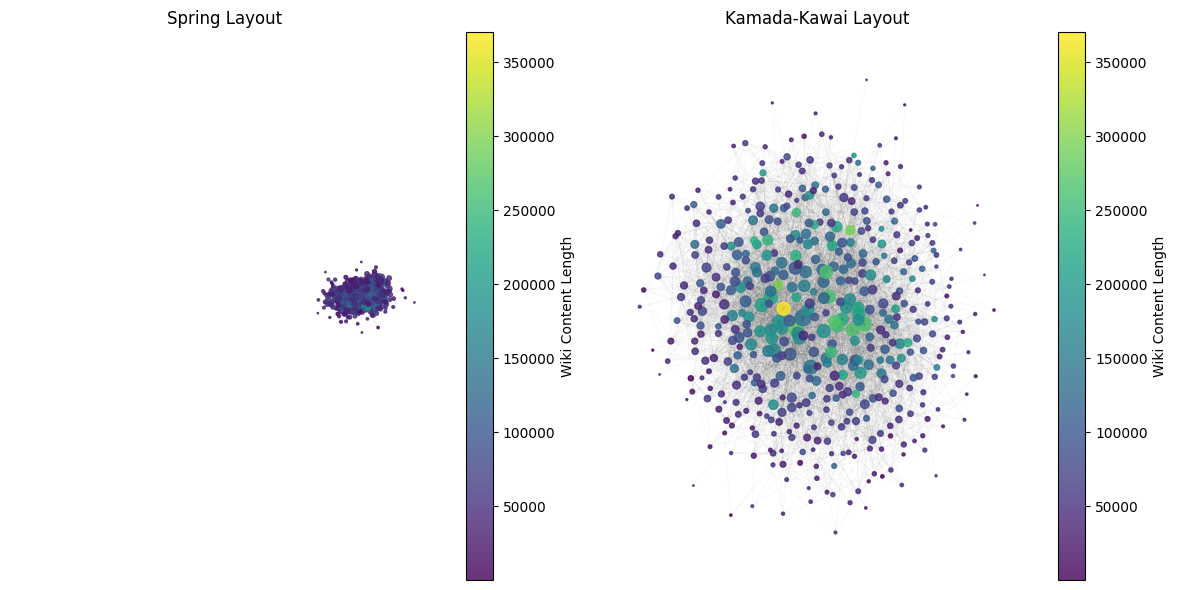

In [8]:
from matplotlib import cm

degrees = dict(G_band_undirected.degree())
node_sizes = [degrees[n] for n in G_band_undirected.nodes]

cmap = cm.viridis
nodes_kwargs = {
    "G": G_band_undirected,
    "node_size": node_sizes,
    "node_color": [bands_content_lengths[n] for n in G_band_undirected.nodes],
    "cmap": cmap,
    "alpha": 0.8,
}
edges_kwargs = {
    "G": G_band_undirected,
    "alpha": 0.04,
    "width": 0.5,
}
# Spring Layout graph
plt.figure(figsize=(12, 6))
plt.subplot(121)
pos_spring = nx.spring_layout(G_band_undirected, seed=42)
nodes_spring = nx.draw_networkx_nodes(pos=pos_spring, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_spring, **edges_kwargs)
plt.title("Spring Layout")
plt.axis("off")
plt.colorbar(nodes_spring, label="Wiki Content Length")
# Kamada-Kawai Layout graph
plt.subplot(122)
pos_kamada = nx.kamada_kawai_layout(G_band_undirected)
nodes_kamada = nx.draw_networkx_nodes(pos=pos_kamada, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_kamada, **edges_kwargs)
plt.title("Kamada-Kawai Layout")
plt.axis("off")
plt.colorbar(nodes_kamada, label="Wiki Content Length")

plt.tight_layout()
plt.show()

### Contributions

- Aryan:
- Juan
- Vlad